In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import os
import polars as pl
import seaborn as sns
import squarify

i_dont_know_label = "UNCATEGORIZED"
df = pl.read_csv('../src/LLM Ingredient Labeling/llama_cpp_grammar/labeled_ingredients_Athene-V2-Chat-Q4_K_M-v4.csv', separator='\t')

df = df.with_columns(
    pl.col("answer_path").str.replace("I DON'T KNOW", i_dont_know_label, literal=True)
).with_columns(
    pl.col("answer_path").str.split(" -> ").alias("taxonomy_split")
)

df = df.with_columns([
    pl.col("taxonomy_split").list.get(0).str.strip_chars().alias("level_1"),
    pl.col("taxonomy_split").list.get(1).str.strip_chars().alias("level_2"),
    pl.col("taxonomy_split").list.get(2).str.strip_chars().alias("level_3"),
    pl.col("taxonomy_split").list.get(3).str.strip_chars().alias("level_4")
])

In [17]:
# def update_plt_rc(small_size=16, medium_size=26, bigger_size=30):
#     plt.rc('font', size=medium_size)  # controls default text sizes
#     plt.rc('axes', titlesize=bigger_size)  # fontsize of the axes title
#     plt.rc('axes', labelsize=bigger_size)  # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=bigger_size)  # fontsize of the tick labels
#     plt.rc('ytick', labelsize=bigger_size)  # fontsize of the tick labels
#     plt.rc('legend', fontsize=bigger_size)  # legend fontsize
#     plt.rc('figure', titlesize=bigger_size)

# Distribution across the first-level taxonomy


=== Distribution across the first-level taxonomy ===
shape: (6, 2)
┌────────────────────────┬───────┐
│ level_1                ┆ count │
│ ---                    ┆ ---   │
│ str                    ┆ u32   │
╞════════════════════════╪═══════╡
│ AGRICULTURAL PROCESSED ┆ 10018 │
│ CROPS                  ┆ 3064  │
│ MEAT PRODUCTS          ┆ 2013  │
│ ANIMAL DERIVED         ┆ 1237  │
│ FISHING                ┆ 690   │
│ UNCATEGORIZED          ┆ 290   │
└────────────────────────┴───────┘


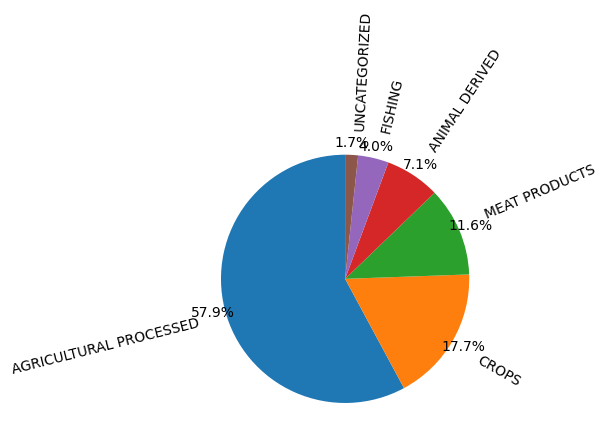

In [18]:
taxonomy_counts = (
  df.group_by("level_1")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

# Convert to pandas for plotting
taxonomy_counts_pd = taxonomy_counts

print("\n=== Distribution across the first-level taxonomy ===")
print(taxonomy_counts_pd)

fig = plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    taxonomy_counts_pd["count"],
    labels=taxonomy_counts_pd["level_1"],
    autopct='%1.1f%%',
    startangle=90,
    rotatelabels=True,
    labeldistance=1.2,  # move labels outside
    pctdistance=1.1,     # adjust percentage text position
)


# textprops={'rotation': 45}
# for t in texts:
#     t.set(**textprops)

# percent = np.array([t.get_text() for t in autotexts])

# plt.legend(loc='center left', bbox_to_anchor=(-0.1, 1.),
#            fontsize=8)

fig.tight_layout()
fig.show()


# Distribution of i_dont_know_label labels
We sum how many times i_dont_know_label appears at levels 2, 3, or 4


=== Distribution of 'I DON'T KNOW' across taxonomy levels ===
   num_idk_levels  count
0             NaN  14911
1             0.0   1615
2             1.0    786


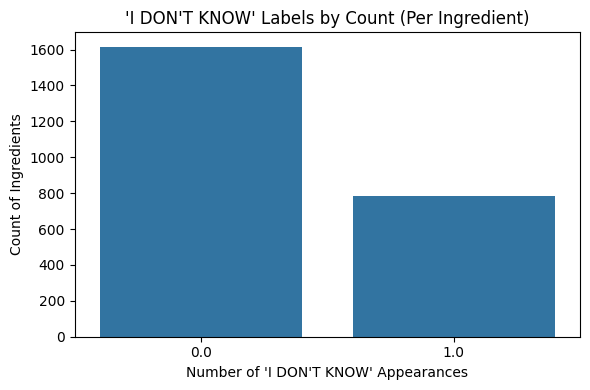

In [19]:
df = df.with_columns(
    (
        (pl.col("level_2") == i_dont_know_label).cast(pl.Int64) +
        (pl.col("level_3") == i_dont_know_label).cast(pl.Int64) +
        (pl.col("level_4") == i_dont_know_label).cast(pl.Int64)
    ).alias("num_idk_levels")
)

idk_distribution = (
    df.group_by("num_idk_levels")
      .agg(pl.len().alias("count"))
      .sort("num_idk_levels")
)

idk_distribution_pd = idk_distribution.to_pandas()

print("\n=== Distribution of 'I DON'T KNOW' across taxonomy levels ===")
print(idk_distribution_pd)

plt.figure(figsize=(6, 4))
sns.barplot(x="num_idk_levels", y="count", data=idk_distribution_pd)
plt.title("'I DON'T KNOW' Labels by Count (Per Ingredient)")
plt.xlabel("Number of 'I DON'T KNOW' Appearances")
plt.ylabel("Count of Ingredients")
plt.tight_layout()
plt.show()

# Top second-level categories (excluding i_dont_know_label)


=== Distribution across second-level taxonomy (excluding 'I DON'T KNOW') ===
shape: (20, 3)
┌───────────────────┬──────────┬────────────────────────┐
│ level_2           ┆ count    ┆ level_1                │
│ ---               ┆ ---      ┆ ---                    │
│ str               ┆ f64      ┆ str                    │
╞═══════════════════╪══════════╪════════════════════════╡
│ SWEETS            ┆ 0.149706 ┆ AGRICULTURAL PROCESSED │
│ VEGETABLES        ┆ 0.066475 ┆ CROPS                  │
│ SPICIES           ┆ 0.05184  ┆ CROPS                  │
│ DRESSING          ┆ 0.051224 ┆ AGRICULTURAL PROCESSED │
│ PROCESSED GRAINS  ┆ 0.047736 ┆ AGRICULTURAL PROCESSED │
│ …                 ┆ …        ┆ …                      │
│ FISH              ┆ 0.019286 ┆ FISHING                │
│ BREAKFAST CEREALS ┆ 0.014704 ┆ AGRICULTURAL PROCESSED │
│ GRAIN FLOUR       ┆ 0.014225 ┆ AGRICULTURAL PROCESSED │
│ MILK              ┆ 0.013473 ┆ ANIMAL DERIVED         │
│ SUGAR             ┆ 0.013063 ┆ AGRI

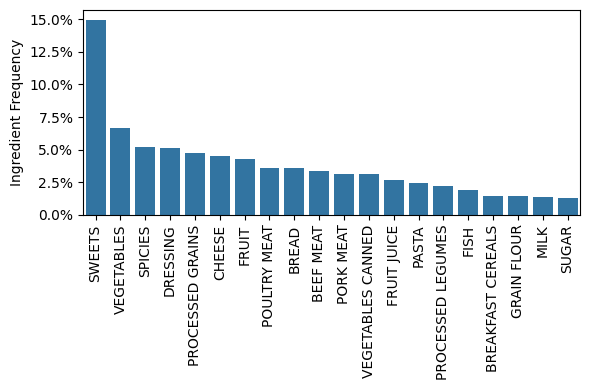

/tmp/ipykernel_3758667/377084281.py:54: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  second_level_counts_pd_squarify = second_level_counts_pd_squarify.with_columns(


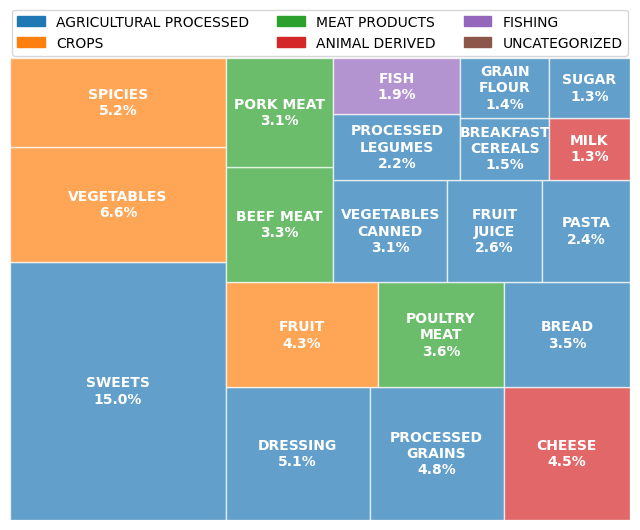

In [20]:
valid_second_level = df.filter(pl.col("level_2") != i_dont_know_label)
second_level_counts = (
    valid_second_level
    .group_by("level_2")
    .agg(
        pl.len().alias("count"),
        pl.col("level_1").first().alias("level_1")
    )
    .with_columns(pl.col("count") / pl.col("count").sum())
    .top_k(20, by="count")
    .sort("count", descending=True)
)
second_level_counts = second_level_counts.with_columns(
    pl.col('level_2').str.replace('\s\(.*', '')
)

print("\n=== Distribution across second-level taxonomy (excluding 'I DON'T KNOW') ===")
print(second_level_counts)

plt.figure(figsize=(6, 4))
sns.barplot(
    x="level_2", y="count",
    data=second_level_counts.to_pandas()
)
plt.xlabel("")
# plt.xlabel("Food Commodity Typology (Level 2)")
plt.ylabel("Ingredient Frequency")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# Convert second_level_counts['count'] and 'level_2' to appropriate lists if needed
# Replace whitespaces with newline characters in level_2 labels
second_level_counts_pd_squarify = second_level_counts.with_columns(
    pl.concat_str(
        pl.when(pl.col("level_2").str.len_chars() > 10).then(pl.col("level_2").str.replace(' ', '\n')).otherwise(pl.col("level_2")),
        pl.lit("\n"),
        (pl.col("count") * 100).round(1).cast(pl.String),
        pl.lit("%")
    ).alias("level_2")
)

# Define a mapping from level_1 to colors
color_mapping = {
    "AGRICULTURAL PROCESSED": "#1f77b4",
    "CROPS": "#ff7f0e",
    "MEAT PRODUCTS": "#2ca02c",
    "ANIMAL DERIVED": "#d62728",
    "FISHING": "#9467bd",
    "UNCATEGORIZED": "#8c564b"
}

second_level_counts_pd_squarify = second_level_counts_pd_squarify.with_columns(
    pl.col("level_1").map_elements(lambda x: color_mapping.get(x, "#cccccc")).alias("color")
)

sizes = second_level_counts_pd_squarify["count"]
labels = second_level_counts_pd_squarify["level_2"]
colors = second_level_counts_pd_squarify["color"]

plt.figure(figsize=(8, 6))
squarify.plot(
    sizes=sizes, label=labels, color=colors, alpha=0.7,
    bar_kwargs={"linewidth": 1.0, "edgecolor": "white"},
    text_kwargs={"fontsize": 10, "color": "white", "fontweight": "bold"},
)
plt.axis("off")
# plt.title("Ingredient Frequency Distribution (Treemap)")
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
plt.legend(handles=legend_handles, ncols=3, loc="upper center", bbox_to_anchor=(0.5, 1.12))
plt.savefig("ingredient_frequency_treemap.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


# Load SU-EATABLE-LIFE WF and CF data to assign estimates for non-ITEM labels

In [ ]:
cf_wf_df = pl.read_csv("../CSV_cfp_wfp_ingredients_2.0.csv", separator=";")

# Rename columns for clarity
cf_wf_df = cf_wf_df.rename({
    "0": "level_1",
    "1": "level_2",
    "2": "level_3",
    "3": "level_4",
})

# Process CF and WF: replace commas with dots and cast them to float
cf_wf_df = cf_wf_df.with_columns([
    pl.col("Cfp").str.replace(",", ".").cast(pl.Float64).alias("CF"),
    pl.col("Wfp").str.replace(",", ".").cast(pl.Float64).alias("WF")
]).fill_null(float('nan'))

cf_schema_overrides = {
    "Carbon Footprint kg CO2eq/kg or l of food ITEM": pl.String,
    "Carbon Footprint g CO2eq/g o cc of food TYPOLOGY": pl.String,
    "Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY": pl.String,
}
su_eatable_cf = pl.read_csv(
    "../SuEatableLife_Food_Fooprint_database_CF.csv",
    separator="\t",
    schema_overrides=cf_schema_overrides,
)
su_eatable_cf = su_eatable_cf.with_columns(
    pl.col(list(cf_schema_overrides.keys())).str.replace(",", ".").str.replace("-", "NaN").cast(pl.Float64)
).fill_null(float('nan'))

wf_schema_overrides = {
    "Water Footprint liters water/kg o liter of food ITEM": pl.String,
    "Water Footprint cc water/g o cc of food TYPOLOGY": pl.String,
    "Water Footprint cc water/g o cc of food sub-TYPOLOGY": pl.String,
}
su_eatable_wf = pl.read_csv(
    "../SuEatableLife_Food_Fooprint_database_WF.csv",
    separator="\t",
    schema_overrides=wf_schema_overrides,
)
su_eatable_wf = su_eatable_wf.with_columns(
    pl.col(list(wf_schema_overrides.keys())).str.replace(",", ".").str.replace("-", "NaN").cast(pl.Float64)
).fill_null(float('nan'))

In [22]:
# Extend cf_wf_df with aggregated rows for taxonomy nodes that are “incomplete”
# (e.g. a node defined only at level_1 without further levels).
# For each taxonomy level (level_1 to level_4), we search in su_eatable_cf/wf for unique labels.
# For a given taxonomy level, if cf_wf_df does not already contain a row having that label in that level 
# with all lower levels empty (or null), then we compute the median CF (from su_eatable_cf)
# and median WF (from su_eatable_wf) for that label and add a new row.

new_rows = []
typology_column_id = 5
sub_typology_column_id = 7
taxonomy_levels = ["level_1", "level_2", "level_3", "level_4"]

for i in range(cf_wf_df.height):
    row = cf_wf_df[i]

    last_level = 4
    while row[0, f"level_{last_level}"] == '-':
        last_level -= 1
    last_level -= 1  # Start from previous level.

    for lvl in range(last_level, 0, -1):
        food_commodity = row[f"level_{lvl}"]
        if (su_eatable_cf[:, sub_typology_column_id] == food_commodity).any():
            cf = su_eatable_cf.filter(su_eatable_cf[:, sub_typology_column_id] == food_commodity)[0, sub_typology_column_id + 1]
        elif (su_eatable_cf[:, typology_column_id] == food_commodity).any():
            cf = su_eatable_cf.filter(su_eatable_cf[:, typology_column_id] == food_commodity)[0, typology_column_id + 1]
        else:
            cf = cf_wf_df.filter(pl.col(f"level_{lvl}") == food_commodity)["CF"].drop_nans().drop_nulls().median()
            cf = cf if cf is not None else float('nan')

        if (su_eatable_wf[:, sub_typology_column_id] == food_commodity).any():
            wf = su_eatable_wf.filter(su_eatable_wf[:, sub_typology_column_id] == food_commodity)[0, sub_typology_column_id + 1]
        elif (su_eatable_wf[:, typology_column_id] == food_commodity).any():
            wf = su_eatable_wf.filter(su_eatable_wf[:, typology_column_id] == food_commodity)[0, typology_column_id + 1]
        else:
            wf = cf_wf_df.filter(pl.col(f"level_{lvl}") == food_commodity)["WF"].drop_nans().drop_nulls().median()
            wf = wf if wf is not None else float('nan')

        new_rows.append(
            row.with_columns(
                pl.col([f"level_{lvl_repl + 1}" for lvl_repl in range(lvl, 4)]).str.replace('.*', '-'),
                pl.lit(cf).alias("CF"),
                pl.lit(wf).alias("WF"),
            )
        )

if new_rows:
    new_rows_df = pl.concat(new_rows, how="vertical").unique(taxonomy_levels)
    # Append the new rows to cf_wf_df.
    extended_cf_wf_df = cf_wf_df.vstack(new_rows_df)
    print("Extended cf_wf_df shape:", extended_cf_wf_df.shape)
else:
    print("No new rows to add.")

final_cf_wf_df = extended_cf_wf_df.select(
    pl.concat_str(["level_1", "level_2", "level_3", "level_4"], separator=' -> ').alias('taxonomy_path'),
    pl.all().exclude([f"level_{lvl}" for lvl in range(1, 5)], "Cfp", "Wfp"),
).with_columns(
    pl.col('taxonomy_path').str.replace_all(' -> -', '', literal=True)
)
final_cf_wf_df

Extended cf_wf_df shape: (583, 8)


taxonomy_path,CF,WF
str,f64,f64
"""AGRICULTURAL PROCESSED -> NUTS…",4.12,NaN
"""AGRICULTURAL PROCESSED -> VEGE…",0.54,2030.0
"""AGRICULTURAL PROCESSED -> NUTS…",1.84,NaN
"""AGRICULTURAL PROCESSED -> FRUI…",2.86,1140.0
"""AGRICULTURAL PROCESSED -> PROC…",1.32,2523.0
…,…,…
"""AGRICULTURAL PROCESSED -> BREA…",1.31,NaN
"""AGRICULTURAL PROCESSED -> PAST…",3.15,4637.0
"""AGRICULTURAL PROCESSED -> WINE""",0.66,524.0


# Join CF and WF information with labeled ingredients based on answer_path matching

In [23]:
labels_df = df.select(
    pl.all().exclude([f"level_{lvl}" for lvl in range(1, 5)] + ["taxonomy_split", "answer_path"]),
    pl.col('answer_path').str.replace_all(f' -> {i_dont_know_label}', '', literal=True)
)

labels_cf_wf_df = labels_df.join(
    final_cf_wf_df,
    left_on='answer_path',
    right_on='taxonomy_path',
    how='left',
    coalesce=True
)

labels_cf_wf_df

index,ingredient,num_idk_levels,answer_path,CF,WF
i64,str,i64,str,f64,f64
0,"""sun - dried cherries""",null,"""AGRICULTURAL PROCESSED""",1.3,1378.0
1,"""root beer concentrate""",null,"""AGRICULTURAL PROCESSED""",1.3,1378.0
2,"""chicken tenderloins""",0,"""MEAT PRODUCTS -> POULTRY MEAT …",3.68,3960.0
3,"""basil chicken sausage link""",0,"""MEAT PRODUCTS -> POULTRY MEAT …",3.68,3960.0
4,"""smoked cheese""",null,"""ANIMAL DERIVED -> CHEESE (GENE…",9.59,5253.0
…,…,…,…,…,…
17307,"""FAGE Total 0%""",null,"""ANIMAL DERIVED -> YOGURT -> YO…",1.69,1540.0
17308,"""almond macaroons""",null,"""AGRICULTURAL PROCESSED -> SWEE…",1.99,2158.0
17309,"""fresh pineapple chunks""",0,"""CROPS -> FRUIT (GENERIC) -> FR…",0.28,255.0


# Distribution of CF and WF for labeled ingredients.

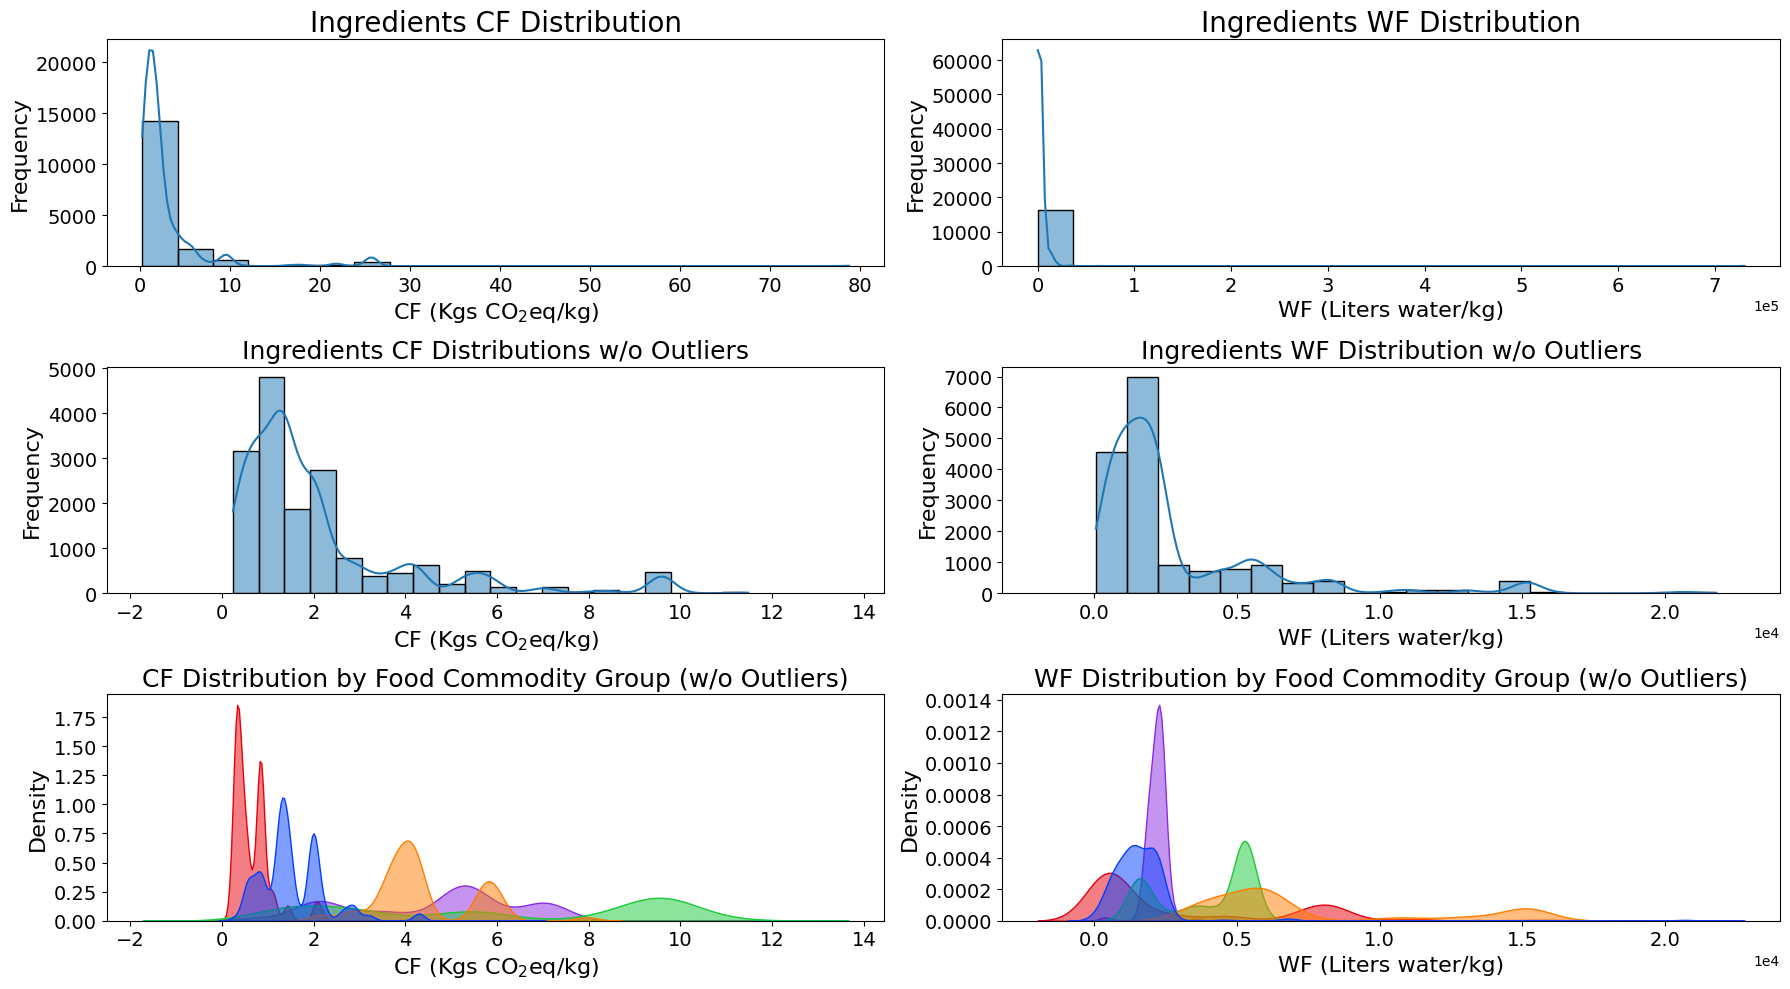

In [24]:
# Convert labels_cf_wf_df to a pandas DataFrame for plotting
labels_cf_wf_pd = labels_cf_wf_df.to_pandas()

# Use the labels_cf_wf_df to create a pandas DataFrame for plotting.
kde_labels_cf_wf_df = labels_cf_wf_df.with_columns(
    pl.col('answer_path').str.split(' ->').list.get(0).alias('level_1')
).to_pandas()

kde_palette = "bright"
cf_outlier_th = 15
wf_outlier_th = 30000

# Plot histograms for CF and WF distributions for labeled ingredients
fig, ax = plt.subplots(3, 2, figsize=(18, 10))
ax[2, 0].sharex(ax[1, 0])
ax[2, 1].sharex(ax[1, 1])

sns.histplot(labels_cf_wf_pd["CF"].dropna(), bins=20, kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Ingredients CF Distribution", fontsize=20)
sns.histplot(labels_cf_wf_pd["WF"].dropna(), bins=20, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Ingredients WF Distribution", fontsize=20)

ax[0, 0].set_xlabel("CF (Kgs CO$_{2}$eq/kg)", fontsize=16)
ax[0, 1].set_xlabel("WF (Liters water/kg)", fontsize=16)
ax[0, 0].set_ylabel("Frequency", fontsize=16)
ax[0, 1].set_ylabel("Frequency", fontsize=16)

sns.histplot(labels_cf_wf_pd["CF"].dropna()[labels_cf_wf_pd["CF"].dropna() < cf_outlier_th], bins=20, kde=True, ax=ax[1, 0])
ax[1, 0].set_title("Ingredients CF Distributions w/o Outliers", fontsize=18)
sns.histplot(labels_cf_wf_pd["WF"].dropna()[labels_cf_wf_pd["WF"].dropna() < wf_outlier_th], bins=20, kde=True, ax=ax[1, 1])
ax[1, 1].set_title("Ingredients WF Distribution w/o Outliers", fontsize=18)

ax[1, 0].set_xlabel("CF (Kgs CO$_{2}$eq/kg)", fontsize=16)
ax[1, 1].set_xlabel("WF (Liters water/kg)", fontsize=16)
ax[1, 0].set_ylabel("Frequency", fontsize=16)
ax[1, 1].set_ylabel("Frequency", fontsize=16)

sns.kdeplot(
    data=kde_labels_cf_wf_df[(kde_labels_cf_wf_df["CF"] < cf_outlier_th)],
    x="CF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=ax[2, 0],
    legend=False
)
ax[2, 0].set_title("CF Distribution by Food Commodity Group (w/o Outliers)", fontsize=18)
ax[2, 0].set_xlabel("CF (Kgs CO$_{2}$eq/kg)", fontsize=16)
ax[2, 0].set_ylabel("Density", fontsize=16)

sns.kdeplot(
    data=kde_labels_cf_wf_df[(kde_labels_cf_wf_df["WF"] < wf_outlier_th)],
    x="WF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=ax[2, 1],
    legend=False
)
ax[2, 1].set_title("WF Distribution by Food Commodity Group (w/o Outliers)", fontsize=18)
ax[2, 1].set_xlabel("WF (Liters water/kg)", fontsize=16)
ax[2, 1].set_ylabel("Density", fontsize=16)

tick_fontsize = 14
for each_ax in ax.flat:
    plt.setp(each_ax.get_xticklabels(), fontsize=tick_fontsize)
    plt.setp(each_ax.get_yticklabels(), fontsize=tick_fontsize)

ax[0, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax[2, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

plt.tight_layout()
fig.savefig("labeled_ingredients_cf_wf_distributions.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

# ----- Generate and save the legend in a separate file -----
# Get the unique food commodity groups and use the same palette.
levels = sorted(kde_labels_cf_wf_df["level_1"].unique())
palette = sns.color_palette(kde_palette, len(levels))
legend_handles = [mpatches.Patch(color=palette[i], label=level) for i, level in enumerate(levels)]

fig_leg = plt.figure(figsize=(12, 2))
# Create a legend in the center using all handles in a single row.
fig_leg.legend(handles=legend_handles, loc='center', ncol=len(legend_handles), fontsize=16)
fig_leg.canvas.draw()
fig_leg.savefig("kde_cf_wf_distributions_legend.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.close(fig_leg)

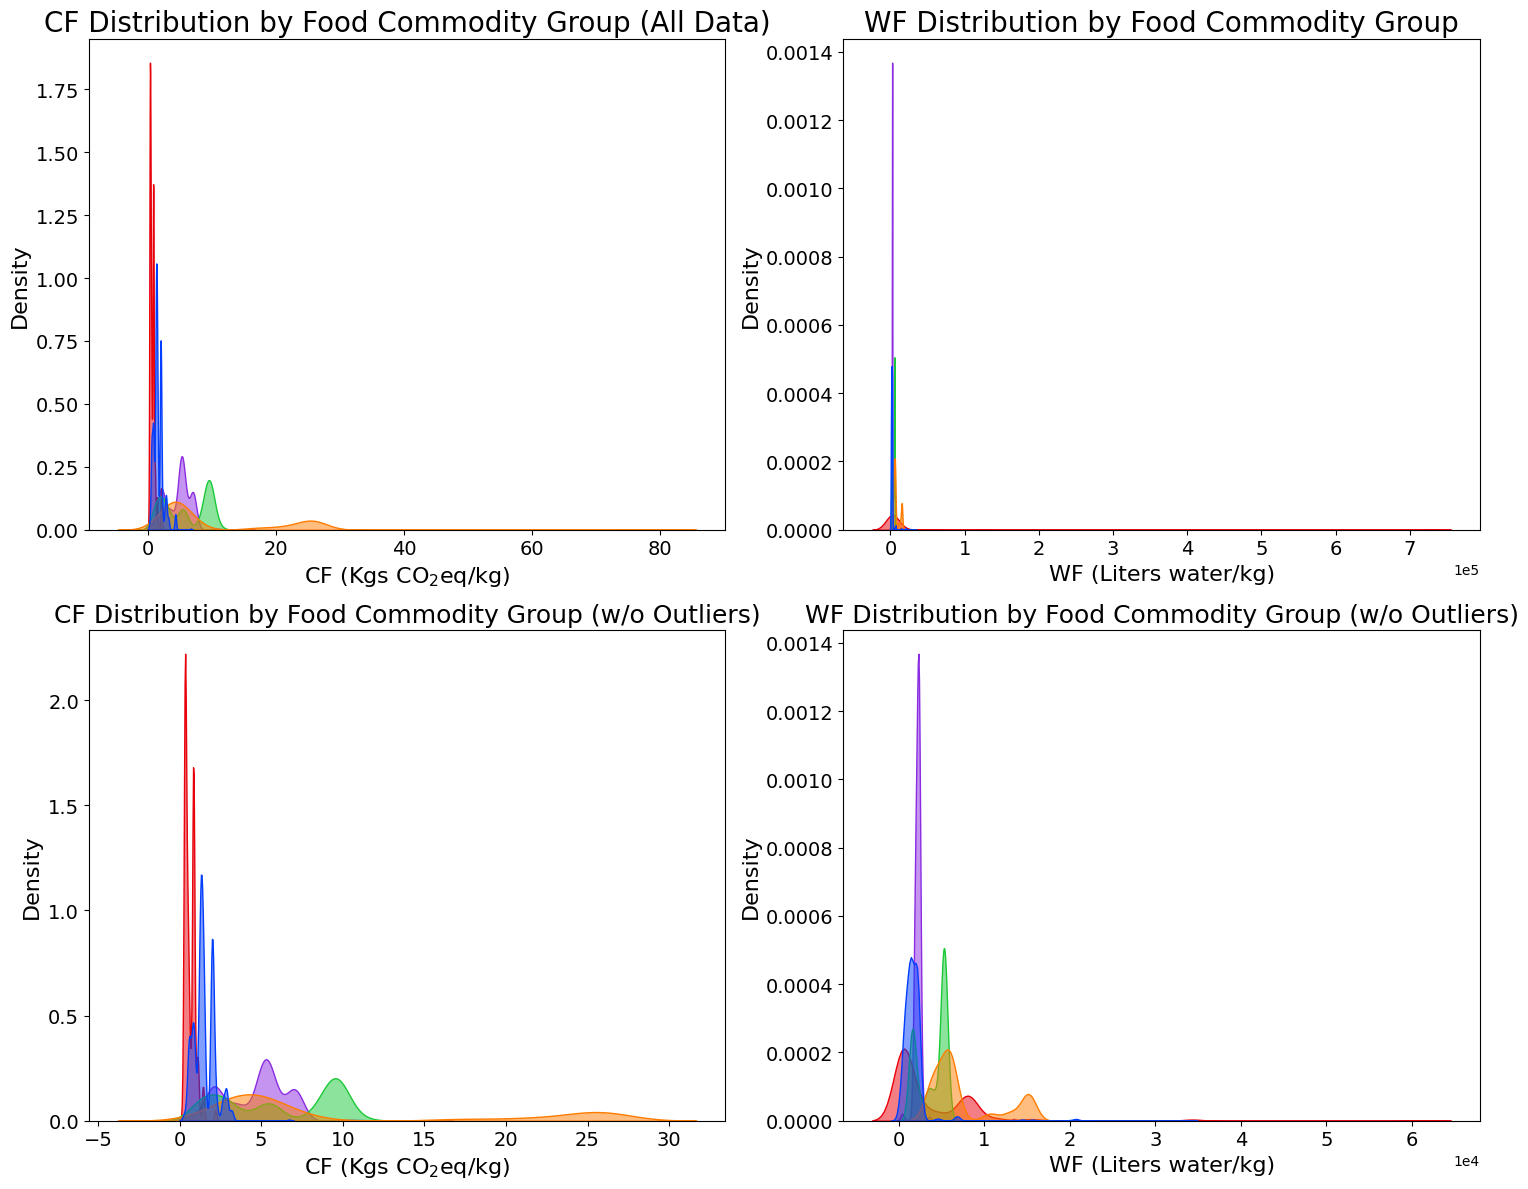

In [25]:
# Use the labels_cf_wf_df to create a pandas DataFrame for plotting.
kde_labels_cf_wf_df = labels_cf_wf_df.with_columns(
    pl.col('answer_path').str.split(' ->').list.get(0).alias('level_1')
).to_pandas()

kde_palette = "bright"

# Create a figure with two rows and two columns for KDE plots.
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Top row: Full-data KDE plots (with legend disabled).
sns.kdeplot(
    data=kde_labels_cf_wf_df,
    x="CF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=axs[0, 0],
    legend=False
)
axs[0, 0].set_title("CF Distribution by Food Commodity Group (All Data)", fontsize=20)
axs[0, 0].set_xlabel("CF (Kgs CO$_{2}$eq/kg)", fontsize=16)
axs[0, 0].set_ylabel("Density", fontsize=16)

sns.kdeplot(
    data=kde_labels_cf_wf_df,
    x="WF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=axs[0, 1],
    legend=False
)
axs[0, 1].set_title("WF Distribution by Food Commodity Group", fontsize=20)
axs[0, 1].set_xlabel("WF (Liters water/kg)", fontsize=16)
axs[0, 1].set_ylabel("Density", fontsize=16)

# Bottom row: KDE plots without outliers.
filtered_df = kde_labels_cf_wf_df[(kde_labels_cf_wf_df["CF"] < 50) & (kde_labels_cf_wf_df["WF"] < 100000)]

sns.kdeplot(
    data=filtered_df,
    x="CF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=axs[1, 0],
    legend=False
)
axs[1, 0].set_title("CF Distribution by Food Commodity Group (w/o Outliers)", fontsize=18)
axs[1, 0].set_xlabel("CF (Kgs CO$_{2}$eq/kg)", fontsize=16)
axs[1, 0].set_ylabel("Density", fontsize=16)

sns.kdeplot(
    data=filtered_df,
    x="WF",
    hue="level_1",
    fill=True,
    common_norm=False,
    palette=kde_palette,
    alpha=0.5,
    ax=axs[1, 1],
    legend=False
)
axs[1, 1].set_title("WF Distribution by Food Commodity Group (w/o Outliers)", fontsize=18)
axs[1, 1].set_xlabel("WF (Liters water/kg)", fontsize=16)
axs[1, 1].set_ylabel("Density", fontsize=16)

# Adjust tick label font sizes.
tick_fontsize = 14
for ax in axs.flat:
    plt.setp(ax.get_xticklabels(), fontsize=tick_fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=tick_fontsize)

axs[0, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
axs[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

plt.tight_layout()
fig.savefig("kde_cf_wf_distributions.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

# ----- Generate and save the legend in a separate file -----
# Get the unique food commodity groups and use the same palette.
levels = sorted(kde_labels_cf_wf_df["level_1"].unique())
palette = sns.color_palette(kde_palette, len(levels))
legend_handles = [mpatches.Patch(color=palette[i], label=level) for i, level in enumerate(levels)]

fig_leg = plt.figure(figsize=(12, 2))
# Create a legend in the center using all handles in a single row.
fig_leg.legend(handles=legend_handles, loc='center', ncol=len(legend_handles), fontsize=16)
fig_leg.canvas.draw()
fig_leg.savefig("kde_cf_wf_distributions_legend.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.close(fig_leg)

# distribuzione di CF e WF aggregati fra i vari ingredienti di ogni ricetta sulle diverse macro-categorie (nuove) trovate. Quindi si mostra se le ricette in HUMMUS hanno o meno un impatto ambientale alto (in termini di CF e WF)

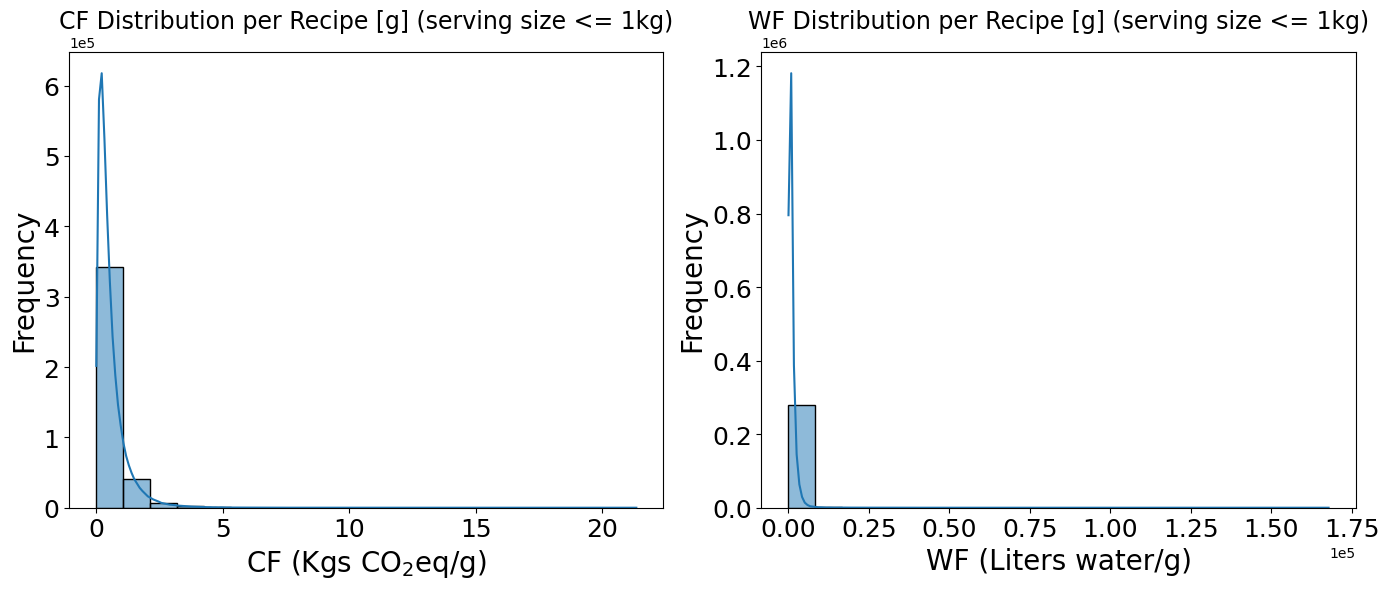

In [26]:
# In Python, generate figures that show the distribution of CF and WF across recipes inside binned_recipes_df. To do so, you need to connect
# labels_cf_wf_df with binned_recipes_df by leveraging the ingredients list at the column "ingredient_food_kg_names". To guarantee a fair comparison,
# normalize CF and WF on 100g of recipe by means of the "serving_size", by assuming that CF and WF are instead based on 1 kg of product
from ast import literal_eval

binned_recipes_df = (
    pl.scan_csv(
        os.path.join(os.pardir, os.pardir, 'FoodHabitsPersonalTraits', 'hummus_raw_data', 'recipes_pp_binned.csv'),
        separator=','
    )
    .select(['recipe_id', 'ingredient_food_kg_names', 'servingSize [g]'])
    .drop_nulls()  # drop recipes whose ingredients have not been connected with FoodKG
    .with_columns(pl.col('servingSize [g]').abs())  # assumes negative serving sizes were incorrectly entered
    .collect()
)

recipes_exploded = (
    binned_recipes_df
    .with_columns(
        pl.col("ingredient_food_kg_names").map_elements(literal_eval, return_dtype=pl.List(pl.String))
    )
    .explode("ingredient_food_kg_names")
    .with_columns(
        pl.col("ingredient_food_kg_names").str.replace('"', '').str.strip_chars().alias("ingredient")
    )
)

# Join with labels_cf_wf_df (assumes a match between ingredient names)
# Use a left join so that only ingredients with a matching CF/WF are kept.
recipe_ingredients = recipes_exploded.join(
    labels_cf_wf_df.select(["ingredient", "CF", "WF"]),
    on="ingredient",
    how="left",
    coalesce=True
)

# Aggregate CF and WF contributions per recipe.
# Here, we simply sum the CF and WF values of the matched ingredients.
# (It is assumed that the ingredient CF/WF values are per kg of ingredient.)
recipe_env = (
    recipe_ingredients
    .group_by("recipe_id")
    .agg(
        pl.col("CF").mean().alias("recipe_CF_kg"),  # total CF per kg recipe (before normalization)
        pl.col("WF").mean().alias("recipe_WF_kg"),
        pl.col("servingSize [g]").first()
    )
)

# Join back with the original recipes to obtain serving_size (in grams)
# and compute normalized CF and WF per recipe.
# Since the CF/WF values are per 1 kg of food, dividing by 1000 gives the value per gram.
# Thus, a recipe with a serving size of 30 grams will have its CF/WF equal to (CF/WF per gram) * 30.
recipes_with_env = (
    recipe_env
    .with_columns([
        ((pl.col("recipe_CF_kg") / 1000) * pl.col("servingSize [g]")).alias("CF_recipe"),
        ((pl.col("recipe_WF_kg") / 1000) * pl.col("servingSize [g]")).alias("WF_recipe")
    ])
)

recipes_with_env.write_csv('recipes_with_cf_wf.csv', separator='\t')

# Convert to pandas for plotting.
serving_size_th = 1000
recipes_with_env_pd = (
    recipes_with_env
    .filter(pl.col('servingSize [g]') <= serving_size_th)
    .to_pandas()
)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(recipes_with_env_pd["CF_recipe"].dropna(), bins=20, kde=True, ax=ax[0])
ax[0].set_title(f"CF Distribution per Recipe [g] (serving size <= {serving_size_th // 1000}kg)", fontsize=17)
ax[0].set_xlabel("CF (Kgs CO$_{2}$eq/g)", fontsize=20)
ax[0].set_ylabel("Frequency", fontsize=20)

sns.histplot(recipes_with_env_pd["WF_recipe"].dropna(), bins=20, kde=True, ax=ax[1])
ax[1].set_title(f"WF Distribution per Recipe [g] (serving size <= {serving_size_th // 1000}kg)", fontsize=17)
ax[1].set_xlabel("WF (Liters water/g)", fontsize=20)
ax[1].set_ylabel("Frequency", fontsize=20)

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 0))

# Adjust tick label font sizes.
tick_fontsize = 18
for each_ax in ax.flat:
    plt.setp(each_ax.get_xticklabels(), fontsize=tick_fontsize)
    plt.setp(each_ax.get_yticklabels(), fontsize=tick_fontsize)

fig.tight_layout()
plt.savefig('cf_wf_distributions_over_recipes_[g].png', dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()